<a href="https://colab.research.google.com/github/athens-igg/training_NN/blob/main/withhh_qpso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()   # select kaggle.json

{}

In [ ]:

!mkdir -p ~/.kaggle
!cp "kaggle (12).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle datasets download -d purushomohan/dfu-wagners-classification

Dataset URL: https://www.kaggle.com/datasets/purushomohan/dfu-wagners-classification
License(s): unknown
  0% 0.00/44.6M [00:00<?, ?B/s]
100% 44.6M/44.6M [00:00<00:00, 2.48GB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
!unzip -q dfu-wagners-classification.zip -d /content/drive

In [ ]:
input_train_data="/content/drive/Dataset/Training"
qpso_train_data="/content/drive/qpso_Dataset/QPSO_Training"

input_valid_data="/content/drive/Dataset/Validation"
qpso_valid_data="/content/drive/qpso_Dataset/qpso_Validation"

In [ ]:
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 28.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def qpso_segmentation(image, max_iter=30, swarm_size=15):
    # --- QPSO Implementation (Otsu-based fitness) ---
    def fitness(image, threshold):
        # Otsu’s between-class variance
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    particles = np.random.randint(1,255,(swarm_size,))
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]

    for _ in range(max_iter):
        mbest = np.mean(pbest)
        for i in range(swarm_size):
            phi = np.random.rand()
            p = phi*pbest[i] + (1-phi)*gbest
            u = np.random.rand()
            beta = 1.0
            new_particle = p + beta*np.sign(u-0.5)*np.abs(mbest - particles[i])*np.log(1.0/u)
            new_particle = int(np.clip(new_particle, 1, 254))

            f = fitness(image, new_particle)
            if f > pbest_fitness[i]:
                pbest[i] = new_particle
                pbest_fitness[i] = f
                if f > max(pbest_fitness):
                    gbest = new_particle
        particles = pbest.copy()

    return gbest






In [ ]:
def process_training_dataset(input_train_data, qpso_train_data):
    for cls in os.listdir(input_train_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path = os.path.join(input_train_data, cls)
        output_path = os.path.join(qpso_train_data, cls)
        os.makedirs(output_path, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            img_path = os.path.join(input_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            best_thresh = qpso_segmentation(img)
            _, segmented = cv2.threshold(img, best_thresh, 255, cv2.THRESH_BINARY)


            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path = os.path.join(output_path, img_name)
            cv2.imwrite(save_path, segmented_rgb)

        print(f"✅ Finished QPSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path}")



In [ ]:
# Example usage
input_train_data="/content/drive/Dataset/Training"
qpso_train_data="/content/drive/qpso_Dataset/QPSO_Training"
process_training_dataset(input_train_data, qpso_train_data)

Processing Grade 0 ...


100%|██████████| 53/53 [00:01<00:00, 28.85it/s]


✅ Finished QPSO Segmentation for Grade 0.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 557/557 [00:19<00:00, 28.81it/s]


✅ Finished QPSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 152/152 [00:05<00:00, 29.12it/s]


✅ Finished QPSO Segmentation for Grade 2.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 2
Processing Grade 1 ...


100%|██████████| 141/141 [00:04<00:00, 29.28it/s]


✅ Finished QPSO Segmentation for Grade 1.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 1
Processing Grade 3 ...


100%|██████████| 62/62 [00:02<00:00, 29.23it/s]

✅ Finished QPSO Segmentation for Grade 3.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 3


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def qpso_segmentation(image, max_iter=30, swarm_size=15):
    # --- QPSO Implementation (Otsu-based fitness) ---
    def fitness(image, threshold):
        # Otsu’s between-class variance
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    particles = np.random.randint(1,255,(swarm_size,))
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]

    for _ in range(max_iter):
        mbest = np.mean(pbest)
        for i in range(swarm_size):
            phi = np.random.rand()
            p = phi*pbest[i] + (1-phi)*gbest
            u = np.random.rand()
            beta = 1.0
            new_particle = p + beta*np.sign(u-0.5)*np.abs(mbest - particles[i])*np.log(1.0/u)
            new_particle = int(np.clip(new_particle, 1, 254))

            f = fitness(image, new_particle)
            if f > pbest_fitness[i]:
                pbest[i] = new_particle
                pbest_fitness[i] = f
                if f > max(pbest_fitness):
                    gbest = new_particle
        particles = pbest.copy()

    return gbest

In [ ]:
def process_validation_dataset(input_valid_data,qpso_valid_data):
    for cls in os.listdir(input_valid_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path2 = os.path.join(input_valid_data, cls)
        output_path2 = os.path.join(qpso_valid_data, cls)
        os.makedirs(output_path2, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path2)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            img_path2 = os.path.join(input_path2, img_name)
            img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
            if img2 is None:
                continue

            best_thresh = qpso_segmentation(img2)
            _, segmented = cv2.threshold(img2, best_thresh, 255, cv2.THRESH_BINARY)

            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb2 = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path2 = os.path.join(output_path2, img_name)
            cv2.imwrite(save_path2, segmented_rgb2)

        print(f"✅ Finished QPSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path2}")

In [ ]:
# Example usage
input_valid_data="/content/drive/Dataset/Validation"
qpso_valid_data="/content/drive/qpso_Dataset/qpso_Validation"
process_validation_dataset(input_valid_data, qpso_valid_data)


Processing Grade 0 ...


100%|██████████| 12/12 [00:00<00:00, 28.89it/s]


✅ Finished QPSO Segmentation for Grade 0.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 49/49 [00:01<00:00, 25.81it/s]


✅ Finished QPSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 19/19 [00:00<00:00, 29.17it/s]


✅ Finished QPSO Segmentation for Grade 2.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 2
Processing Grade 1 ...


100%|██████████| 16/16 [00:00<00:00, 29.28it/s]


✅ Finished QPSO Segmentation for Grade 1.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 1
Processing Grade 3 ...


100%|██████████| 20/20 [00:00<00:00, 29.16it/s]

✅ Finished QPSO Segmentation for Grade 3.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 3


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np

# ============================
# 0) Hyperparameters
# ============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_BASE = 40
EPOCHS_FINE = 25
N_CLASSES = 5
DROPOUT_RATE = 0.5
L2_WEIGHT = 1e-4

# ============================
# 1) Data Augmentation
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7, 1.3],
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    channel_shift_range=20.0,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    qpso_train_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    qpso_valid_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# ============================
# 2) Class Weights
# ============================
y_train = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# ============================
# 3) Model Definition
# ============================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(N_CLASSES, activation="softmax", kernel_regularizer=l2(L2_WEIGHT))(x)

model = Model(inputs=base_model.input, outputs=output)

# ============================
# 4) Compile Base Model
# ============================
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================
# 5) Callbacks
# ============================
checkpoint = ModelCheckpoint(
    "/content/drive/Dataset/best_qpso_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=4, verbose=1),
    checkpoint
]

# ============================
# 6) Train Base Model
# ============================
history_base = model.fit(
    train_gen,
    epochs=EPOCHS_BASE,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

# ============================
# 7) Fine-Tune Last Layers
# ============================
# Unfreeze last 60 layers
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=5e-6),  # small LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

# ============================
# 8) Save Final Model
# ============================
model.save("/content/drive/Dataset/final_qpso_model.keras")


Found 965 images belonging to 5 classes.
Found 116 images belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.2532 - loss: 2.3682 - val_accuracy: 0.1810 - val_loss: 1.8544 - learning_rate: 0.0010
Epoch 2/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.4311 - loss: 1.8419 - val_accuracy: 0.2759 - val_loss: 1.6652 - learning_rate: 0.0010
Epoch 3/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.5099 - loss: 1.6034 - val_accuracy: 0.3362 - val_loss: 1.5956 - learning_rate: 0.0010
Epoch 4/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.5451 - loss: 1.5574 - val_accuracy: 0.4052 - val_loss: 1.4271 - learning_rate: 0.0010
Epoch 5/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.5701 - loss: 1.4153 - val_accuracy: 0.4655 - val_loss: 1.3361 - learning_rate: 0.0010
Epoch 6/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.5852 - loss: 1.2902 - val_accuracy: 0.4138 - val_loss: 1.5252 - learning_rate: 0.0010
Epoch 7/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.5501 - loss: 1.

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_qpso_model = load_model("/content/drive/Dataset/final_qpso_model.keras")

# Evaluate on validation data
val_loss, val_acc = best_qpso_model.evaluate(val_gen)
print(f"Best Validation Accuracy: {val_acc*100:.2f}%")
print(f"Best Validation Loss: {val_loss:.4f}")


ValueError: File not found: filepath=/content/drive/Dataset/final_qpso_model.keras. Please ensure the file is an accessible `.keras` zip file.

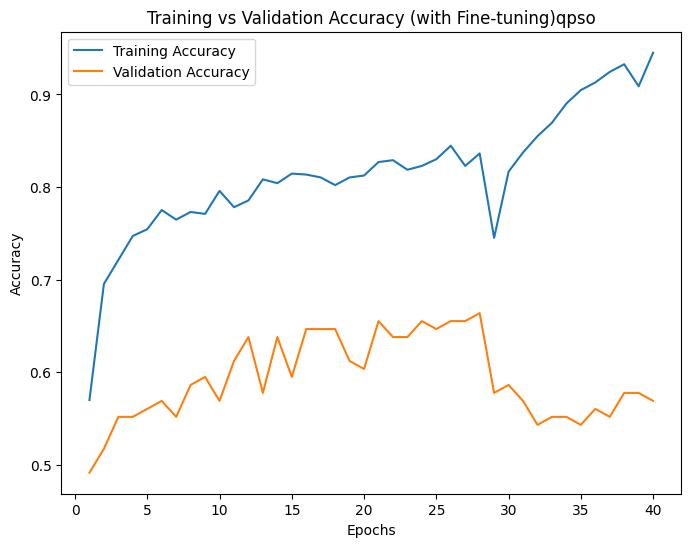

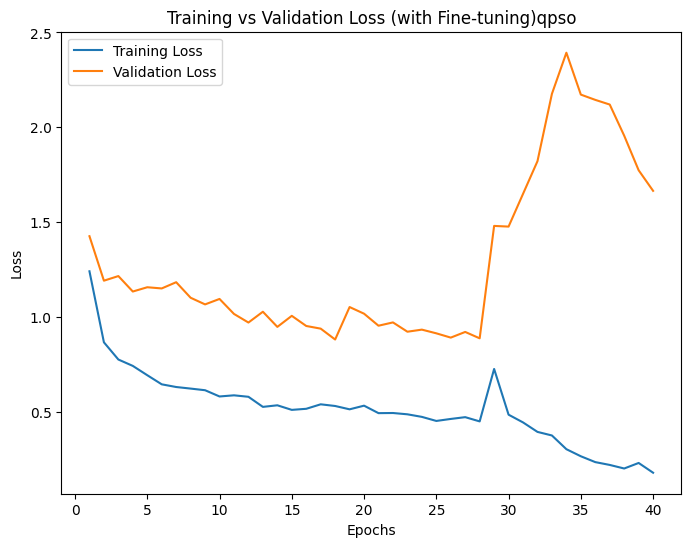

In [ ]:
import matplotlib.pyplot as plt

# Merge history and fine-tuning history
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (with Fine-tuning)qpso')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (with Fine-tuning)qpso')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/Dataset/best_qpso_model.h5')


Saving Screenshot 2025-09-21 233831.png to Screenshot 2025-09-21 233831 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


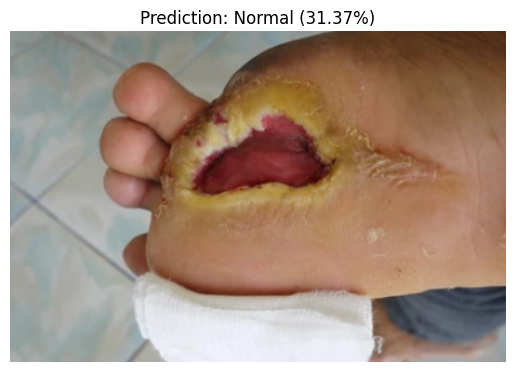

In [ ]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade1", "Grade2", "Grade3", "Normal" ]
filename = list(uploaded.keys())[0]

# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
pred = best_qpso_model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

In [ ]:


# Load baseline model from Notebook 1
baseline_model = load_model('/content/drive/Dataset/best_baseline_model.h5')

# Evaluate baseline on raw validation set
baseline_loss, baseline_acc = baseline_model.evaluate(val_raw_gen)
print(f"Baseline Accuracy on raw images: {baseline_acc*100:.2f}%")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/Dataset/best_baseline_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
qpso_model = load_model('/content/drive/Dataset/best_qpso_implemented_model.h5')
qpso_loss, qpso_acc = qpso_model.evaluate(val_gen)
print(f"accuracy on QPSO Segmented Accuracy: {qpso_acc*100:.2f}%")


In [ ]:
print(f"Accuracy Improvement: {qpso_acc*100 - baseline_acc*100:.2f}%")
